<a href="https://colab.research.google.com/github/Gobihanath/DTect/blob/main/DTect_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import cv2

input_shape = (256,256 , 3)  # 3 means the rgb format

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
Image_Width = 256
Image_Height = 256
Image_Size = (Image_Width, Image_Height)
Image_Channel = 3
batch_size=128

In [ ]:
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset/Dtect | Dataset | New",
    seed=123,         #If you want to ensure that the shuffling of your dataset is the same across different runs, you can keep the seed value constant. If you don't care about reproducibility, you can omit the seed parameter or use a different value for each run.
    shuffle=True,
    image_size=Image_Size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5001 files belonging to 10 classes.


In [ ]:
class_names = data_set.class_names
class_names

['Person 1',
 'Person 10',
 'Person 2',
 'Person 3',
 'Person 4',
 'Person 5',
 'Person 6',
 'Person 7',
 'Person 8',
 'Person 9']

In [ ]:
def get_dataset_partitions_tf(data_set, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(data_set)

    if shuffle:
        data_set = data_set.shuffle(shuffle_size, seed=123)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = data_set.take(train_size)
    val_ds = data_set.skip(train_size).take(val_size)
    test_ds = data_set.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data_set)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

24
8
8


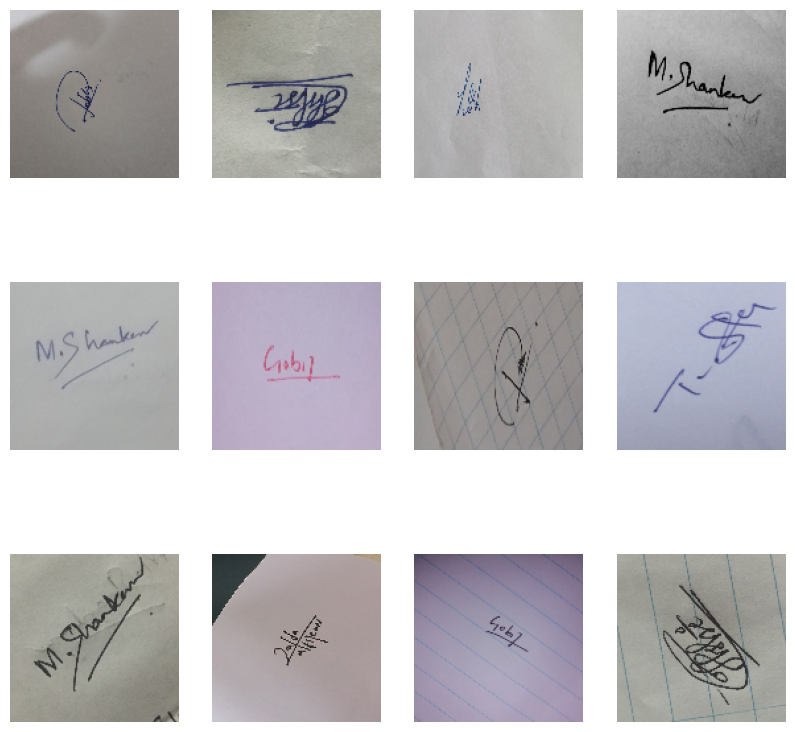

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 256, 256, 3)
(128, 10)


In [ ]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**Early Stopping 1**

In [ ]:
ACCURACY_THRESHOLD = 0.95

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        accuracy = logs.get('accuracy')  # Use 'accuracy' instead of 'acc'
        if accuracy is not None and accuracy > ACCURACY_THRESHOLD:
            print("\nReached %2.2f%% accuracy, so stopping training!!" % (ACCURACY_THRESHOLD * 100))
            self.model.stop_training = True

# Instantiate a callback object
early_stopping = myCallback()

**Early Stopping 2**

Early stopping callback function

In [ ]:
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=10,
                              mode='auto',                #will Stop the training if there is no decrease in the metric “val_loss” of our model by at least 0.001 value after or in any 10 consecutive epochs.
                              start_from_epoch=0
                                             )

In [ ]:
history  = model.fit(
    train_ds,
    batch_size=128,
    validation_data=val_ds,
    validation_steps = 7,
    verbose=1,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
24/24 [==============================] - 1666s 26s/step - loss: 4.6255 - accuracy: 0.1080 - val_loss: 2.3009 - val_accuracy: 0.1071
Epoch 2/30
24/24 [==============================] - 833s 26s/step - loss: 2.2640 - accuracy: 0.1138 - val_loss: 2.2776 - val_accuracy: 0.1138
Epoch 3/30
24/24 [==============================] - 835s 26s/step - loss: 2.2437 - accuracy: 0.1473 - val_loss: 2.2678 - val_accuracy: 0.1440
Epoch 4/30
24/24 [==============================] - 841s 26s/step - loss: 2.2311 - accuracy: 0.2133 - val_loss: 2.2179 - val_accuracy: 0.2857
Epoch 5/30
24/24 [==============================] - 826s 26s/step - loss: 2.0488 - accuracy: 0.2889 - val_loss: 2.0816 - val_accuracy: 0.2934
Epoch 6/30
24/24 [==============================] - 794s 24s/step - loss: 1.9383 - accuracy: 0.3329 - val_loss: 1.9861 - val_accuracy: 0.2958
Epoch 7/30
24/24 [==============================] - 831s 26s/step - loss: 1.5567 - accuracy: 0.4619 - val_loss: 1.8455 - val_accuracy: 0.3873
Epoch

In [ ]:
train_loss, train_acc = model.evaluate(train_ds)
print('Training accuracy:', train_acc)

val_loss, val_acc = model.evaluate(val_ds)
print('Validation accuracy:', val_acc)

24/24 [==============================] - 319s 4s/step - loss: 0.2469 - accuracy: 0.9211
Training accuracy: 0.9210972189903259
8/8 [==============================] - 262s 4s/step - loss: 0.2662 - accuracy: 0.9180
Validation accuracy: 0.91796875


In [ ]:
model.save('/content/drive/MyDrive/ML Trained Models/Dtect_Prediction_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/ML Trained Models/Dtect_Prediction_Model.keras')

In [ ]:
model.save('/content/drive/MyDrive/ML Trained Models/Dtect_Prediction_Model.json')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/ML Trained Models/Dtect_Prediction_Model.h5')